# DSA Final Project: Analyzing Angela Merkel's Speeches Using NLP

A project by Johanna Mehler (j-mehler), Florian Winkler (f-winkler), Jiayu Yang (zeitgeist-hash) and Nassim Zoueini (nassimzoueini) 
##____________
##Introduction
After four terms in office, former German Chancellor Angela Merkel recently exited the political stage she had led for sixteen years, kickstarting much debate about her legacy for Germany, Europe, and the world. 
To gain a better understanding of her legacy, this project seeks to analyze Angela Merkel’s speeches using natural language processing (NLP) methods such as topic modeling and sentiment analysis. 
The project aims at answering policy-relevant questions such as: How have political priorities changed over four terms of Angela Merkel’s chancellorship? How did her speeches change tone in response to significant historical events during her mandate (e.g., global financial crisis 2008/09, Fukushima nuclear disaster 2011, refugee crisis 2015, Covid-19)? 

The project is structured along the following order:

Step 1: Setup

Step 2: Pre-Processing Data

Step 3: Exploring the Data through a Word Cloud

Step 4: Topic Modeling

Step 5: Sentiment Analysis

##____________________________________________________________________________

##Project Limitations

A selection of speeches by the former Chancellor can be found in English on the official website of the [Federal Chancellery of Germany](https://www.bundeskanzler.de/bk-en/news). However, scraping these speeches from this website presents two major challenges:
1. The government website is hosted on a secure server, which made web scraping not possible without authorization.
2. Implementing this project during a political transitional phase in Germany put more limitations on access to data, i.e. regarding the website structure (change from Angela Merkel to Olaf Scholz) and the availability of speeches.

Within the aforementioned limitations, the project targets 120 speeches manually exported into a CSV file, which is used as the main source of data. As the main objective of this project is to demonstrate and use NLP methods, due to data limitations, the expected output does not necessarily match the political reality.

##___________________________________________________________________
##About this Notebook
 
Intermediate steps are preceded by a brief description to explain how each step contributes to the overall objective of the project. In these descriptions, you will also find the used packages and expected outputs.

A *print* or *display* command is visible at the end of selected code chunks and can be un-commented to view a summary, glimpse or subset of the interim result.

As this project is hosted in a collaborative environment, restarting runtime, especially after loading packages, might be necessary to avoid warnings in the future.


## Step 1: Setup

In this step, the packages and dataset needed for our anaylsis are installed and imported.

###1.1 Loading packages
As described in the introduction, the workflow followed to achieve a successful analysis includes pre-processing data, topic modeling and a sentimentent analysis in addition to data wrangling and visualization necessary across the various steps.
#____________

####For Pre-processing,
the packages used are NLTK and spaCy.
####For Topic Modeling,
the packages used are gensim and scikitlearn.
###For Sentiment Analysis,
the packages used are NLTK and textblob.
####For Data Wrangling,
the packages used are re, numpy and panda.
####For Visualization,
the packages used are matplotlib, seaborn, wordcloud and pyLDAvis (specific for topic modeling-related plots).

#___________

Deprecation warnings are ignored to avoid user confusion and any unwanted termination of the program.

In [ ]:
!pip install pyLDAvis

In [ ]:
!pip install pandas==1.3.1

In [ ]:
!pip install wordcloud

In [ ]:
# Import re, numpy and panda for data wrangling
import re
import numpy as np
import pandas as pd
from pprint import pprint
from pandas import DataFrame
import tqdm

# Import NLTK and spacy for pre-processing text data
import nltk 
nltk.download('stopwords')
from nltk.corpus import stopwords
import spacy
import en_core_web_sm

# Import Gensim for topic modeling
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import gensim.test.utils 

# Import plotting tools
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
%matplotlib inline

# For sentiment analysis
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.sentiment import sentiment_analyzer
from textblob import TextBlob

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

###1.2 Importing data

The data set is imported to the work environment as a csv file.

For a systematic manipulation of the imported data, the dataframe of Angela Merkel's speeches is expected to present the following columns:
- ID
- text
- title
- date
- country
- speaker
- length
- language



In [ ]:
# Load Data
df = pd.read_csv("https://raw.githubusercontent.com/f-winkler/DSA_2021_FinalProject_Merkel/main/Merkel_english_speeches_v2.csv", sep=";")
df = df.drop('Column1',1) # Removes a duplicate column for ID

# Explore data set
# with pd.option_context('display.max_rows', 10, 'display.max_columns', None):
# display(df)

## Step 2: Pre-Processing Data
Pre-processing the data follows the below-listed steps:
1.   Preparing a list of stop words to be removed from the corpus
2.   Tokenizing words and removing punctuation
3.   Creating bigrams and trigrams models
4.   Removing stopwords, making bigrams and lemmatizing 





###2.1 Preparing stopwords

English stopwords are imported from the NLTK package. The list of stopwords is extended to filter out additional irrelevant words to our analysis that have been frequently used and would alter the reults for topic modeling and sentiment analysis (e.g. having the word 'country' in each modeled topic does not have any added value and might alter the result). Extending the stopwords list was conducted in a trial-and-error process upon collaborative evaluation.

In [4]:
# Set up our stopwords vector from NLTK
stop_words = stopwords.words('english')

# Add stopwords
stop_words.extend(['want', 'must', 'also', 'need', 'many', 'make', 'take', 'takes', 'took', 'taken', 'say', 'see', 'would', 'well', 'country', 'countries', 'countrys', 'year', 'use', 'people', 'today', 'work', 'time', 'much', 'however', 'thank', 'german', 'germany', 'world', 'together', 'one', 'therefore', 'like', 'every', 'still', 'year', 'another'])

# print(stop_words)

###2.2 Tokenizing words and removing punctuation

Word tokenization and punctuation removal is done through the simple_preprocess() function of the Gensim package.



In [5]:
# define function sent_to_words
"""
function name: sent_to_words
purpose: tokenize words and remove punctuation
input argument: sentences
output: tokenized words without punctuation
in-function methods: gensim.utils.simple_preprocess() to tokenize and remove punctuation by setting the argument deacc=TRUE, yield to generate needed output repetitively
"""
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuation

data_words = list(sent_to_words(df['text']))

# print(data_words[:1])

###2.3 Creating bigram and trigram models

Building bigrams and trigrams allows for capturing unique expressions that are a combination of words frequently used together in the text, e.g. 'United States' or 'thank you for'.

Building such phrase models allows for creating a clean corpus for the analysis at a later stage.

In [ ]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100)
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
# print(trigram_mod[bigram_mod[data_words[0]]])

###2.4 Removing stopwords, making bigrams and lemmatizing words

Stopwords removal, creating bigrams, and lemmatization happen at this stage to clean the text through the below defined functions. Lemmatization brings all words back to their linguistic origin and thus allows for a uniform treatment of the tokenized words after being cleaned from stopwords.

In [7]:
# Remove stopwords
"""
function name: remove_stopwords
purpose: remove stopwords
input argument: texts
output: words without stopwords
in-function methods: simple_preprocess()
"""
def remove_stopwords(texts):
    return[[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

# Create bigrams and trigrams
"""
function name: make_bigrams
purpose:build bigrams
input argument: text
output: bigram character expressions
in-function methods: bigram_mod[]
"""
def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

"""
function name: make_trigrams
purpose:build trigrams
input argument: text
output: trigram character expressions
in-function methods: trigram_mod[],bigram_mod[]
"""
def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

# Lemmatize 
"""
function name: lemmatization
purpose: turn words into their lemmas
input argument: text and allowed postags (noun, adjectives, verbs, adverbs as a list defined as:['NOUN', 'ADJ', 'VERB', 'ADV'])
output: text
in-function methods: token.lemma()
https://spacy.io/api/annotation
"""
def lemmatization(texts, allowed_postags = ['NOUN', 'ADJ', 'VERB', 'ADV']):
    
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent))
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

###2.5 Running the functions sequentially

Next, the data without stopwords is used to form bigrams. The output is then used to run lemmatization allowing us to standardize words that may vary based on grammatical structure. Next, we initialize spaCy by loading the tagger for efficiency (senter is disabled by default).

At the end of this step, the expected output is a clean list of relevant, lemmatized words including bigrams.

In [8]:
# Remove stop words
data_words_nostops = remove_stopwords(data_words)

# Form bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model
nlp = en_core_web_sm.load(disable = ['parser', 'ner'])

# Run lemmatization keeping only noun, adj, vb, adv
data_lemma = lemmatization(data_words_bigrams, 
                           allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

# print(data_lemma[:1])

### Step 3: Exploring the Data (*through Word Cloud*)

In [9]:
def wordCloud(section):
    comment_words = '' 
    stopwords = set(stop_words) 

    # Iterate through the csv file 
    for val in section: 

        # Typecaste each val to string 
        val = str(val) 

        # Split the value 
        tokens = val.split() 

        comment_words += " ".join(tokens)+" "

    word_cloud = WordCloud(width = 800, height = 800, 
                    background_color ='white', 
                    stopwords = stopwords, 
                    min_font_size = 10).generate(comment_words) 

    # Plot the WordCloud image                        
    plt.figure(figsize = (8, 8), facecolor = None) 
    plt.imshow(word_cloud) 
    plt.axis("off") 
    plt.tight_layout(pad = 0)

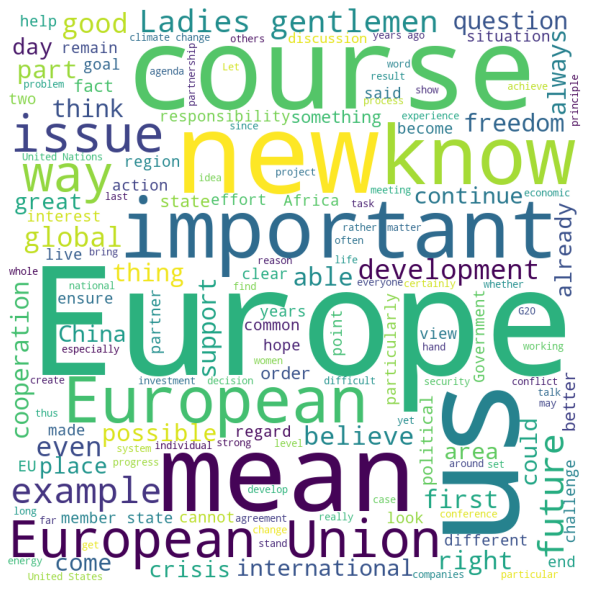

In [10]:
wordCloud(df['text'])

## Step 4: Topic Modeling

### 4.1 Topic Modeler 1: Latent Dirichlet Allocation (LDA)

The Latent Dirichlet Allocation (LDA) is a popular tool for uncovering patterns (topics) in large sets of text data. It is an unsupervised machine learning technique that identifies “clusters of words” that can be grouped into discrete concepts or topics. The model does not identify these topics on its own beyond a vector of individual word associations. As a result, it is up to the analyst to explore these latent topic clusters and to assess what concept(s) best describe the statistical associations uncovered by the algorithm.





###4.1.1 Creating the dictionary and corpus needed for LDA modeling

- The two main inputs to the LDA topic model are a dictionary (id2word) and a corpus, consisting of a document term matrix.
- Gensim creates a unique ID for each word in the document. The produced corpus is a mapping of *(word_id, word_frequency)*.

In [11]:
# Create dictionary
id2word = corpora.Dictionary(data_lemma)

# Create corpus
texts = data_lemma

# Create a document term matrix (term document frequency)
corpus = [id2word.doc2bow(text) for text in texts]

# View the corpus
# print(corpus[:1])

# If desired, see what word corresponds to a given ID (pass the ID as a key to the dictionary)
# id2word[10]

# Or: Display a human-readable form of the corpus itself (term-frequency)
# [[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

###4.1.2 Build the LDA model

With the current form of data and functions, all the requirements to train the LDA model are fulfilled.

In addition to the corpus and the dictionary, a successful run of the LDA model requires the user to specify the number of topics that are needed. For LDA, a topic is the cluster of words noticed to be used within the same context.
#_________
Useful information:

- Model hyperparameters can be thought of as settings for a machine learning algorithm that are tuned by the data scientist before training, in our case, number of topics K.
- Model parameters can be thought of as what the model learns during training, such as the weights for each word in a given topic.

- *alpha* and *beta* are hyperparameters that affect sparsity of the topics. In our LDA modeling, alpha parameter is Document-Topic Density, the beta parameter is Word-topic density. Iterations can normally start with 0,01 and 0,1 as values for alpha and beta respectively.

- *Chunksize* is the number of documents to be used in each training chunk. 

- *update_every* determines how often the model parameters should be updated and passes is the total number of training passes.

*For further information, see references.*

In [12]:
lda_model = gensim.models.LdaMulticore(corpus = corpus,
                                       id2word = id2word,
                                       num_topics = 7,
                                       random_state = 42,                                        
                                       chunksize = 100,
                                       passes = 10,                                   
                                       per_word_topics = True,
                                       minimum_probability = 0)


Now that the LDA model is trained, we can save and load the model object.

In [13]:
# Save model in pickle format to working directory
lda_model.save("lda_merkel.pkl")

# Load model back into the workspace from working directory
lda_model = gensim.models.LdaModel.load("lda_merkel.pkl")

###4.1.3 View the topics in the LDA model

We chose to run the LDA model with 7 different topics where each topic is a combination of keywords and each keyword contributes a certain weightage to the topic. 

We limited the number of topics to 7 to comply with the project limitations described in the introduction, and after several iterations by changing this number and examining coherence, which was better at 7 topics.

Expanding topic modeling into a larger number of topics might cause unwanted discrepancies due to limited data.
#_______
To view the keywords for each topic and the weightage (importance) of each keyword use *lda_model.print_topics()*.

In [14]:
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.006*"year" + 0.006*"development" + 0.005*"new" + 0.005*"mean" + '
  '0.005*"way" + 0.005*"know" + 0.005*"good" + 0.004*"course" + '
  '0.004*"important" + 0.004*"economic"'),
 (1,
  '0.007*"course" + 0.007*"sustainable" + 0.007*"important" + '
  '0.006*"development" + 0.006*"come" + 0.006*"goal" + 0.006*"achieve" + '
  '0.006*"good" + 0.005*"future" + 0.005*"sustainability"'),
 (2,
  '0.012*"climate" + 0.008*"new" + 0.006*"goal" + 0.006*"target" + '
  '0.006*"european" + 0.005*"national" + 0.005*"international" + '
  '0.005*"example" + 0.005*"become" + 0.005*"course"'),
 (3,
  '0.010*"european" + 0.009*"value" + 0.008*"important" + 0.008*"rule" + '
  '0.007*"partner" + 0.007*"course" + 0.006*"relation" + 0.006*"state" + '
  '0.006*"law" + 0.006*"order"'),
 (4,
  '0.002*"illegal_migration" + 0.002*"institute" + 0.002*"legally" + '
  '0.001*"general_assembly" + 0.001*"qualified" + 0.001*"migration" + '
  '0.001*"immeasurable" + 0.001*"sovereign" + 0.001*"nutrition" + '
  '0.001

###4.1.4 Topic identification

As explained in the description of the LDA topic modeler, the next step would be to manually identify topics from LDA keywords (human decision).

Since defining topics from the findings above does not necessarily seem to be straightforward, even if the number of topics was increased or decreased, exploring the perplexity and the coherence of the model would help to assess the efficiency of the modeling.

###4.1.5 Compute model perplexity and coherence score

Model perplexity and topic coherence provide a measure to judge how good a given topic model is.

Perplexity is one of the intrinsic evaluation metrics, and is widely used for language model evaluation. It captures how surprised a model is of new data it has not seen before, and is measured as the normalized log-likelihood of a held-out test set. The lower the perplexity is, the more efficient is the modeler.

Topic coherence measures score a single topic by measuring the degree of semantic similarity between high scoring words in the topic. These measurements help distinguish between topics that are semantically interpretable topics and topics that are artifacts of statistical inference.

Typically, coherence score depends on the number of topics run by the model, therfeore, by trial-and-error, we could choose the number of topics that gave the highest coherence index.

In [15]:
# Compute model perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))

# Compute coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemma, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -7.708450681667762

Coherence Score:  0.3036299535865091


###4.1.6 Visualize the topic keywords from the LDA model

On the left-hand side plot of pyLDAvis package’s interactive chart below, each bubble represents a topic from the LDA model. 

The larger the bubble, the more prevalent that topic. A good topic model will have fairly big, non-overlapping bubbles scattered throughout the chart instead of being clustered in one quadrant. A model with too many topics will typically have many overlaps, small sized bubbles clustered in one region of the chart. 

If you move the cursor over one of the bubbles, the words and bars on the right-hand side will update. These words are the salient keywords that form the selected topic.

In [16]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = gensimvis.prepare(lda_model, corpus, id2word)
vis

/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.033446 -0.007416       1        1  63.234683
1      0.009428 -0.096450       2        1  11.746820
3      0.094183  0.061994       3        1   8.337038
5      0.085250 -0.048826       4        1   7.363475
2      0.038587 -0.041222       5        1   7.269446
6     -0.004054  0.138275       6        1   1.956354
4     -0.256840 -0.006355       7        1   0.092185, topic_info=              Term        Freq       Total Category  logprob  loglift
277      important  453.000000  453.000000  Default  30.0000  30.0000
119         crisis  247.000000  247.000000  Default  29.0000  29.0000
796          issue  353.000000  353.000000  Default  28.0000  28.0000
179       european  252.000000  252.000000  Default  27.0000  27.0000
329           live  209.000000  209.000000  Default  26.0000  26.0000
...            ...         ...         ...      ...      ...      ...
2994       legally    0.136886    2.742407   Topic7  -6.3991   3.9917
4252     qualified    0.087219    1.736557   Topic7  -6.8498   3.9979
274   immeasurable    0.060259    3.517942   Topic7  -7.2196   2.9221
2380     migration    0.064560   53.909991   Topic7  -7.1506   0.2616
3081     sovereign    0.055153   12.860230   Topic7  -7.3081   1.5374

[548 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
987       2  0.777362  abandon
987       6  0.097170  abandon
1         1  0.649708     able
1         2  0.038218     able
1         3  0.123147     able
...     ...       ...      ...
611       6  0.009466     year
986       1  0.899050    young
986       2  0.052885    young
986       3  0.031731    young
986       6  0.010577    young

[1157 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 4, 6, 3, 7, 5])

###Interpretation of the graphs
- The intertopic distance map shows us that topics 1-6 all have overlaps, some of them being a complete overlap and some only in parts. 
- This supports the first assumption that the model is not sufficient to determine segregated topics.
- In order to find the optimal LDA model specification in terms of number of topics, in the next step, we will run a model coherence analysis 


###4.1.7 Model coherence analysis

Our approach to finding the optimal number of topics is to build many LDA models with different values of number of topics (k) and pick the one that gives the highest topic coherence value.
#_____________

The *compute_coherence_values()* (see below) trains multiple LDA models and provides the models and their corresponding coherence scores.

In [17]:
"""
    function name: compute_coherence_values
    purpose: compute topic coherence values
    input argument: the used dictionary (here it is Gensim), corpus (also from gensim), texts: a list of input texts, limit to set a maximum number of topics
    output: model_list a list of LDA topic models, coherence_values: coherence values corresponding to the LDS topics
    in-function methods: gensim.models.LdaMulticore(),CoherenceModel()
   
"""

def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):

     coherence_values = []
     model_list = []
     for num_topics in range(start, limit, step):
        model = gensim.models.LdaMulticore(corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

     return model_list, coherence_values


In [18]:
# Can take a long time to run
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemma, start=1, limit=10, step=1)

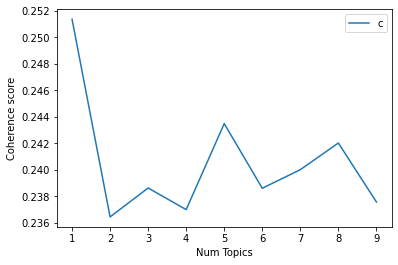

In [19]:
# Show graph
limit=10; start=1; step=1;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [20]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 1  has Coherence Value of 0.2514
Num Topics = 2  has Coherence Value of 0.2365
Num Topics = 3  has Coherence Value of 0.2386
Num Topics = 4  has Coherence Value of 0.237
Num Topics = 5  has Coherence Value of 0.2435
Num Topics = 6  has Coherence Value of 0.2386
Num Topics = 7  has Coherence Value of 0.24
Num Topics = 8  has Coherence Value of 0.242
Num Topics = 9  has Coherence Value of 0.2376


###4.1.8 Evalauate the LDA model

As the LDA model doesn't seem to be suited well for identifying political topics in speeches within the scope of our data, we will therefore extend the topic modeling process using a non-negative matrix factorization (NMF) algorithm, which is expected to lead to more differentiated results for our specific objective.

## 4.2 Topic modeler 2: Non-negative Matrix Factorization (NMF)

NMF learns topics by directly decomposing the term-document matrix and reduces the dimensions to find the main topics of the speeches.

To use NMF, we start with setting up some modules from the sklearn package.

In [21]:
# from nltk.corpus import stopwords (already there)
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import NMF
from nltk.probability import FreqDist
# from sklearn.metrics.pairwise import cosine_similarity
# from sklearn.cluster import DBSCAN
# from nltk.sentiment.vader import SentimentIntensityAnalyzer

import seaborn as sns
# %matplotlib inline

###4.2.1 Count vectorization (preparing speech data for NFM model)


NMF allows us to fine-tune our model for stopwords and filter out words from the NMF model. 

#________________
The *CountVectorizer()* function of the NMF model allows the above through the following parameters:

- The "*stop_words*" argument removes our pre-defined stop words. 
We used the customized stopword list from step 2 where we combined  NLTK’s stopwords with a list of additional words that were identified after trials. *(See "Step 2: Pre-Processing")*

- "*max_df*" ignores terms that have a document frequency higher than this threshold (in this case, using 1.0, i.e. 100%,  does not remove any words; but this could be lowered to remove very frequent words). Can either be a percentage value (between 0.0 and 1.0) or an integer as the number of frequency of a word.
- "*min_df*" ignores terms that have a document frequency lower than this threshold (in this case, using 1, does not remove any words also. This parameter could also be percentage value between 0.0 and 1.0 or an integer in terms of the frequency of a word).

- "*ngram_range*" of (1, 2) would mean that unigrams and bigrams (words that frequenty occur together, e.g. European Union) are included as single tokens. For now, we only include unigrams.

In [22]:
def remove_numbers(text):
    text = text.lower()
    text = re.sub(r'\d+', '', text)
    return text

#Count vectorizer
cv = CountVectorizer(stop_words=stop_words, max_df=1.0, min_df = 1, ngram_range = (1, 1), preprocessor = remove_numbers)
  
doc_to_word = cv.fit_transform(df.text) # Adds the "text" column of the dataframe as an argument
X_t_cv  = cv.transform(df.text) # Adds the "text" column of the dataframe as an argument


###4.2.2 Run the NMF model

Similarly to LDA, we first choose any number of topics to initiate the model, and then we we use place holders as topic names in order to display the word groups belonging to a topic.

In [23]:
nmf_model = NMF(10) # Choose number of topics here
doc_topic = nmf_model.fit_transform(doc_to_word)

topic_word_nmf = pd.DataFrame(nmf_model.components_.round(3), 
             index = ["topic_1", "topic_2", "topic_3", "topic_4", "topic_5", "topic_6", "topic_7", "topic_8", "topic_9", "topic_10"],
             columns = cv.get_feature_names())
topic_word_nmf

# The table output shows all individual words as separate columns and their correlation with each of the topics.

/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:294: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,aachen,ab,ababa,abandon,abandoning,abandonment,abbas,abbreviated,abductions,abdul,abdullah,abdurrahim,abe,aberrations,abhorrent,abide,abiding,abilities,ability,abiy,abkhazia,ablaze,able,abolish,abolished,abolishing,abolition,abominable,abroad,absolute,absolutely,absorbing,abstract,absurdity,abundance,abundant,abundantly,abuse,abused,abuses,...,yields,yoke,yom,york,youll,young,younger,youre,youth,youths,youve,yozgat,ypres,yugoslav,yugoslavia,yuste,yves,yã¼cel,yã¼cels,zaev,zaldã,zations,zealand,zentrum,zero,zest,zhongli,zib,zone,zoran,zu,zuse,zürich,ángel,å¼ec,élysée,être,özüdoğru,şahin,şimşek
topic_1,0.059,0.000,0.006,0.006,0.024,0.009,0.030,0.000,0.000,0.045,0.000,0.000,0.000,0.002,0.000,0.003,0.000,0.000,0.077,0.017,0.000,0.000,0.676,0.000,0.000,0.000,0.000,0.000,0.009,0.000,0.124,0.001,0.000,0.002,0.000,0.000,0.013,0.045,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.008,0.000,0.000,0.007,0.000,0.000,0.003,0.023,0.034,0.000,0.000,0.010,0.010,0.078,0.000,0.000,0.000,0.004,0.000,0.000,0.005,0.004,0.014,0.055,0.000,0.004,0.000,0.000,0.000,0.024,0.000,0.000,0.000,0.000
topic_2,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.002,0.000,0.000,0.000,0.000,0.000,0.001,0.000,0.000,0.000,0.225,0.000,0.022,0.000,0.000,0.000,0.000,0.000,0.039,0.000,0.003,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.022,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.013,0.032,0.013,0.013,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.046,0.000,0.000,0.000,0.000,0.012,0.000,0.000,0.000,0.000
topic_3,0.000,0.000,0.004,0.005,0.002,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.004,0.000,0.000,0.000,0.490,0.000,0.000,0.000,0.000,0.000,0.031,0.014,0.100,0.015,0.000,0.000,0.000,0.000,0.001,0.000,0.000,0.000,...,0.028,0.000,0.000,0.070,0.000,0.013,0.002,0.000,0.000,0.000,0.002,0.000,0.000,0.000,0.000,0.003,0.002,0.000,0.000,0.000,0.029,0.000,0.000,0.000,0.021,0.000,0.000,0.000,0.018,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.001,0.000
topic_4,0.000,0.000,0.000,0.017,0.000,0.000,0.014,0.000,0.000,0.000,0.000,0.000,0.003,0.000,0.000,0.000,0.000,0.054,0.000,0.000,0.000,0.000,0.165,0.000,0.000,0.000,0.000,0.000,0.020,0.000,0.090,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.039,...,0.016,0.000,0.000,0.004,0.000,0.128,0.000,0.000,0.055,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.004,0.000,0.008,0.000,0.000,0.017,0.008,0.012,0.000,0.000,0.008,0.000,0.030,0.000,0.000,0.007,0.000,0.008,0.000
topic_5,0.099,0.000,0.004,0.000,0.059,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.003,0.000,0.034,0.000,0.000,0.116,0.000,0.017,0.000,0.622,0.000,0.006,0.000,0.000,0.000,0.054,0.000,0.024,0.000,0.007,0.003,0.000,0.000,0.017,0.000,0.000,0.000,...,0.000,0.006,0.000,0.000,0.000,0.038,0.000,0.000,0.099,0.000,0.000,0.000,0.000,0.000,0.000,0.032,0.003,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.001,0.000,0.000,0.016,0.000,0.000,0.000,0.017,0.000,0.001,0.000,0.000,0.000,0.001,0.000
topic_6,0.000,0.032,0.002,0.028,0.000,0.000,0.016,0.000,0.000,0.000,0.000,0.017,0.000,0.005,0.044,0.000,0.021,0.006,0.045,0.000,0.000,0.020,0.420,0.005,0.007,0.032,0.000,0.020,0.090,0.031,0.019,0.000,0.021,0.005,0.024,0.000,0.011,0.092,0.031,0.004,...,0.000,0.007,0.017,0.031,0.000,0.369,0.025,0.000,0.144,0.005,0.000,0.035,0.004,0.000,0.000,0.007,0.000,0.000,0.000,0.000,0.000,0.000,0.002,0.016,0.057,0.011,0.000,0.016,0.000,0.000,0.000,0.016,0.000,0.000,0.011,0.000,0.017,0.017,0.000,0.035
topic_7,0.000,0.000,0.007,0.020,0.002,0.000,0.004,0.055,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.025,0.000,0.000,0.000,0.522,0.000,0.000,0.000,0.000,0.000,0.000,0.011,0.000,0.000,0.000,0.000,0.000,0.000,0.001,0.000,0.000,0.000,...,0.002,0.000,0.000,0.007,0.013,0.045,0.000,0.000,0.007,0.001,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.024,0.000,0.000,0.000,0.00

###4.2.3 Display topics from NMF and their keywords

The ten most important keywords are printed for each topic which are used to identify the topics.

In [24]:
def display_topics(model, feature_names, no_top_words, topic_names=None):
    for ix, topic in enumerate(model.components_):
        if not topic_names or not topic_names[ix]:
            print("\nTopic ", ix +1)
        else:
            print("\nTopic: '",topic_names[ix + 1],"'")
        print(", ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

In [25]:
display_topics(nmf_model, cv.get_feature_names(), 10)


Topic  1
security, us, russia, united, nato, international, european, states, cooperation, ukraine

Topic  2
european, union, europe, member, economic, states, monetary, freedom, crisis, energy

Topic  3
climate, change, energy, emissions, agreement, global, us, protection, paris, new

Topic  4
china, economic, growth, crisis, us, euro, global, course, financial, believe

Topic  5
europe, european, us, rights, council, presidency, eu, future, fundamental, solidarity

Topic  6
freedom, us, internet, values, years, wall, berlin, new, life, first

Topic  7
health, development, global, important, international, us, diseases, course, good, research

Topic  8
africa, development, years, digital, african, us, means, internet, course, global

Topic  9
region, development, security, future, qatar, important, state, education, international, afghanistan

Topic  10
labour, international, ilo, social, conditions, working, organization, women, workers, even


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


###4.2.4 Display distribution of topics across years

After the examination of the results, each set of keywords identified by the NMF modeler, is manually treated to identify the topic.

The data frame of the topics is then edited to extract and save the year of each speech in a new column for further visualization below.

In [26]:
df['date'] = pd.to_datetime(df['date']) # Converts "date" column to pandas datetime format
df['year'] = df['date'].dt.year # Creates new "year" column


In [27]:
doc_topic_nmf = pd.DataFrame(doc_topic.round(3),
                             index = df.year.astype(int), 
                             columns = ["International Security", "European Economy", "Climate Change", "International Economy", "European Values", 
                     "German Unity", "Global Health", "Technology Development", "Regional Development", "Labor Market"])
dtn = doc_topic_nmf.groupby(doc_topic_nmf.index).sum()

with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(dtn)


,International Security,European Economy,Climate Change,International Economy,European Values,German Unity,Global Health,Technology Development,Regional Development,Labor Market
year,,,,,,,,,,
2009,0.501,0.000,0.257,0.487,0.928,4.936,0.000,0.000,0.000,0.000
2010,3.155,9.467,1.857,3.272,3.500,9.387,1.394,1.475,13.959,0.899
2011,6.632,2.329,0.917,14.215,3.019,8.612,1.365,2.841,10.609,7.645
2012,2.404,11.696,5.735,17.937,5.142,5.953,0.131,2.750,0.462,0.282
2013,1.319,2.814,0.538,4.259,1.082,1.264,0.265,0.843,2.428,0.300
2014,4.024,6.699,0.390,2.362,4.333,4.739,0.700,0.923,0.428,0.233
2015,7.128,1.739,8.725,1.505,6.868,1.830,6.273,1.444,3.356,4.989
2016,3.221,0.836,8.161,4.448,1.712,1.362,1.798,1.215,1.006,2.002
2017,5.483,5.632,7.654,3.901,1.671,3.761,14.364,9.641,3.031,3.680


###4.2.5 Create a heatmap to show the distribution of topics across years

Text(0.5, 1.0, 'Speech Topics Over The Years\n')

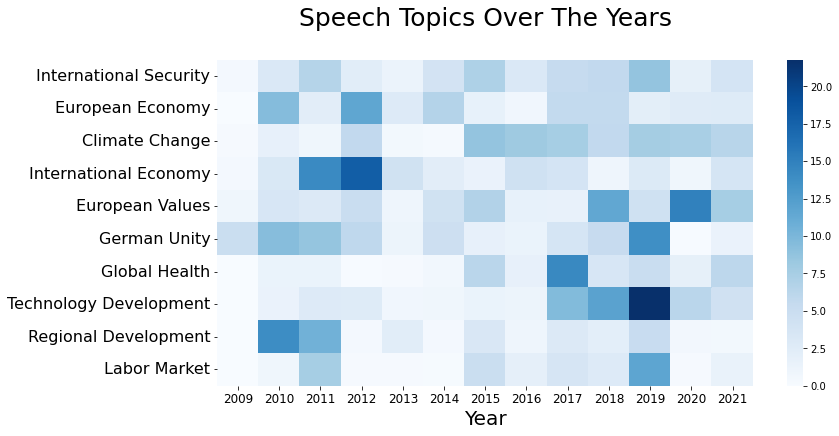

In [28]:
plt.figure(figsize = (12, 6))
sns.heatmap(dtn.T, annot=False, cbar=True, cmap="Blues")
plt.xlabel('Year', fontsize = 20)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 16)
plt.title('Speech Topics Over The Years\n', fontsize=25)

### 4.2.6. Interpret findings
*- The speeches during 2010-2012 and 2017-2020 seem to have a stronger thematic focus than speeches of the other years.*

*- The findings from the NMF algorithm are substantially clearer than from the LDA model, although they still don't match expectations for topics one could have regarding historical events (e.g. financial crisis in 2008/9, wave of refugees in 2015/16, COVID in 2020 etc.)*

## Step 5: Sentiment Analysis

### Method 1: Vader

VADER stands for Valence Aware Dictionary and Sentiment Reasoner. Vader sentiment not only tells if the statement is positive or negative, but also the intensity of emotions.

The results give us numerical values for use of negative, neutral, and positive word choice. The sum of *pos*, *neg*, *neu* intensities give 1.

The compound value reflects the overall sentiment ranging from -1 being very negative and +1 being very positive.

* positive if compound >= 0.5

* neutral if -0.5 < compound < 0.5

* negative if -0.5 >= compound

### Installing Vader

In [ ]:
#Download vader dictionary
nltk.download('vader_lexicon')

###Calculate polarity and compound scores

In [ ]:
# Function to calculate polarity
def vader_sentimentanalysis(text):
  score = SentimentIntensityAnalyzer().polarity_scores(text)
  return score['compound']

# Function to calculate polarity
def vader_score(text):
  score = SentimentIntensityAnalyzer().polarity_scores(text)
  print(score)

# Function to calculate compound scores
def vader_analysis(compound):
  if compound >= 0.5:
    return 'Positive'
  elif compound <= -0.5 :
    return 'Negative'
  else:
    return 'Neutral'

In [ ]:
# Create dataframe for those texts
df_vader = pd.DataFrame(df['text'])

In [ ]:
# Apply the function of calculating polarity and compound to the speech text
df_vader['Vader Sentiment'] = df_vader['text'].apply(vader_sentimentanalysis)
df_vader['Vader Analysis'] = df_vader['Vader Sentiment'].apply(vader_analysis)

df_vader.head()

,text,Vader Sentiment,Vader Analysis
0,"Madam Speaker, Mr. Vice President, Distingui...",0.9998,Positive
1,"Excellencies, Colleagues, Ladies and gentlem...",0.9999,Positive
2,"President Hennessy, President Emeritus Casper...",1.0000,Positive
3,"Ambassador, Excellencies, Ladies and gentlem...",1.0000,Positive
4,"Ladies and gentlemen, On 9 November 1989, Gün...",0.9999,Positive


In [ ]:
# Count pos/neg/neu labels
vader_counts = df_vader['Vader Analysis'].value_counts()
vader_counts

Positive    117
Negative      2
Neutral       1
Name: Vader Analysis, dtype: int64

In [ ]:
# Function to calculate polarity
def vader_score(text):
  score = SentimentIntensityAnalyzer().polarity_scores(text)
  print(score)

In [ ]:
# Show the polarity scores of each speech
df_vader['Positive'] = df_vader['text'].apply(vader_score).head()

{'neg': 0.08, 'neu': 0.765, 'pos': 0.155, 'compound': 0.9998}
{'neg': 0.063, 'neu': 0.773, 'pos': 0.164, 'compound': 0.9999}
{'neg': 0.068, 'neu': 0.726, 'pos': 0.207, 'compound': 1.0}
{'neg': 0.057, 'neu': 0.743, 'pos': 0.199, 'compound': 1.0}
{'neg': 0.061, 'neu': 0.739, 'pos': 0.201, 'compound': 0.9999}
{'neg': 0.085, 'neu': 0.768, 'pos': 0.147, 'compound': 0.9968}
{'neg': 0.035, 'neu': 0.832, 'pos': 0.133, 'compound': 0.9985}
{'neg': 0.042, 'neu': 0.776, 'pos': 0.182, 'compound': 1.0}
{'neg': 0.039, 'neu': 0.785, 'pos': 0.177, 'compound': 1.0}
{'neg': 0.077, 'neu': 0.763, 'pos': 0.16, 'compound': 0.9997}
{'neg': 0.083, 'neu': 0.741, 'pos': 0.176, 'compound': 0.9997}
{'neg': 0.039, 'neu': 0.752, 'pos': 0.209, 'compound': 0.9999}
{'neg': 0.091, 'neu': 0.74, 'pos': 0.169, 'compound': 0.9997}
{'neg': 0.05, 'neu': 0.785, 'pos': 0.165, 'compound': 0.9988}
{'neg': 0.021, 'neu': 0.821, 'pos': 0.158, 'compound': 0.9984}
{'neg': 0.023, 'neu': 0.748, 'pos': 0.229, 'compound': 0.9988}
{'neg': 

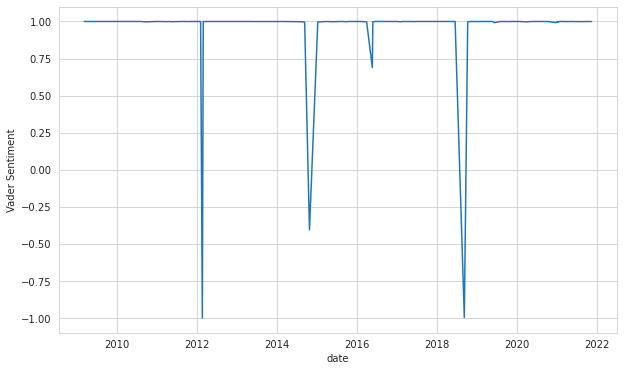

In [ ]:
# Plot the trend of speech compound scores
plt.figure(figsize=(10,6))
sns.set_style("whitegrid")
vader_plot = sns.lineplot(x=df['date'], y=df_vader['Vader Sentiment'])

Findings: 
- Merkel's speeches over the years have been almost always positive, as expected for speeches by political leaders.  We think the goal of those speeches is to inspire the Germans.

### Method 2: TextBlob

TextBlob is a Python library for processing textual data. It provides a consistent API for diving into common natural language processing (NLP) tasks such as part-of-speech tagging, noun phrase extraction, sentiment analysis, and more.

The two measures that are used to analyze the sentiment are:


* Polarity – talks about how positive or negative the opinion is
* Subjectivity – talks about how subjective the opinion is

Polarity ranges from -1 to 1 (1 is more positive, 0 is neutral, -1 is more negative).

Subjectivity ranges from 0 to 1 (0 being very objective and 1 being very subjective).

In [ ]:
# Function to calculate subjectivity
def getSubjectivity(review):
  return TextBlob(review).sentiment.subjectivity

# Function to calculate polarity
def getPolarity(review):
  return TextBlob(review).sentiment.polarity

# Function to analyze the reviews
def analysis(score):
  if score < 0:
    return 'Negative'
  elif score == 0:
    return 'Neutral'
  else:
    return 'Positive'

In [ ]:
# Create dataframe for those text
df_blob = pd.DataFrame(df['text'])

In [ ]:
# Apply the function of calculating polarity and subjectivity to the speech text
df_blob['Polarity'] = df_blob['text'].apply(getPolarity) 
df_blob['Analysis'] = df_blob['Polarity'].apply(analysis)

df_blob.head()

,text,Polarity,Analysis
0,"Madam Speaker, Mr. Vice President, Distingui...",0.107588,Positive
1,"Excellencies, Colleagues, Ladies and gentlem...",0.157156,Positive
2,"President Hennessy, President Emeritus Casper...",0.143114,Positive
3,"Ambassador, Excellencies, Ladies and gentlem...",0.167444,Positive
4,"Ladies and gentlemen, On 9 November 1989, Gün...",0.105821,Positive


In [ ]:
# Count pos/neg labels
tb_counts = df_blob.Analysis.value_counts()
tb_counts

Positive    120
Name: Analysis, dtype: int64

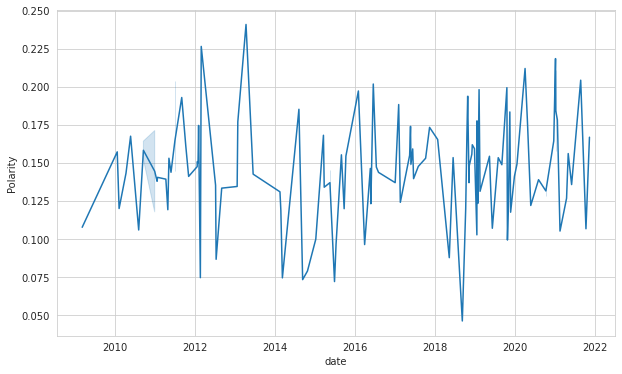

In [ ]:
# Plot the trend of speech polarity
plt.figure(figsize=(10,6))
sns.set_style("whitegrid")
textblob_plot = sns.lineplot(x=df['date'], y=df_blob['Polarity'])

Findings: 
Merkel's speeches over the years have been almost always positive.

Through the analysis of the TextBlob algorithm, the polarity of her speeches varies from 0 to 0.25, which is relatively stable, meaning thus a rather objective and neutral but positive tone.

# Appendix: References and credits

### Speeches

www.bundeskanzlerin.de/bkin-en/news

### Topic Modeler 1: Latent Dirichlet Allocation (LDA)

https://medium.com/the-die-is-forecast/topic-modeling-as-osint-exploring-russian-presidential-speech-topics-over-time-ad6018286d37

https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python


### Topic modeler 2: Non-negative Matrix Factorization (NMF)

https://nicolesemerano.github.io/2020/08/24/Presidents/

https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

https://github.com/nicolesemerano/Metis-Project-4-Presidential-Speeches-NLP/blob/master/%20Presidential_NLP.ipynb

### Word Cloud

https://towardsdatascience.com/simple-wordcloud-in-python-2ae54a9f58e5

### Sentiment Analysis

Vader: https://medium.com/analytics-vidhya/simplifying-social-media-sentiment-analysis-using-vader-in-python-f9e6ec6fc52f

TextBlot: https://towardsdatascience.com/my-absolute-go-to-for-sentiment-analysis-textblob-3ac3a11d524


